In [1]:
# general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline
import seaborn as sns
import itertools
from collections import Counter
# text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# Regular Expression
import re
import string
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, sent_tokenize

#Quality of image:
%config InlineBackend.figure_format = 'svg'


# High Quality Saving
#plt.savefig("graph.svg")
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer


# Import my own functions from utils file:
import import_ipynb
from Utils_Spam_Classifier import *

importing Jupyter notebook from Utils_Spam_Classifier.ipynb


In [2]:
dataDirectory = os.path.join(os.path.dirname(os.getcwd()),'Spam_Classifier\\data')
imageDirectory = os.path.join(os.path.dirname(os.getcwd()),'Spam_Classifier\\images')

df_original = pd.read_table(dataDirectory + "\\SMSSpamCollection", header=None, names=['label', 'message'])
df_original.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [3]:
df_original['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [4]:
def findNumberCount(txt):
    """input: an string
    output: count of numbers appeared in the input string except for time expression (if have ':' character)
    """
    modifiedTxt = re.sub(r'[,.-]', '', txt)
    modifiedTxt = re.sub('[^a-zA-Z0-9:]', ' ', modifiedTxt)
    modifiedTxt = re.sub(r'\s+', ' ', modifiedTxt)
    lst1 = modifiedTxt.split()
    lst1 = [x for x in lst1 if x.isdigit()]
    return len(lst1)


def findToken(txt):
    """input: an string
    output: A list including word token of input text
    """
    return word_tokenize(txt)


def findWordCount(txt):
    """input: an string
    output: count of words appeared in the input string
    """
    return len(txt.split())

def findTokenCount(tokenLst):
    """input: a list of token
    output: count of words presented in list
    """
    return len(tokenLst)

def findAVGWordLen(tokenLst):
    """input: a list of token
    output: Average of word length in the input string
    """
    lengthLst = [len(x) for x in tokenLst]
    return np.mean(lengthLst)

def findNumericWord(tokenLst):
    """input: a list of token
    output: count of numerical word in the input string
    """
    numWordLst = [x for x in tokenLst if x.isdigit()]
    return len(numWordLst)

def findUpperWord(tokenLst):
    """input: a list of token
    output: count of uppercase word in the input string
    """
    upperWordLst = [x for x in tokenLst if x.isupper()]
    return len(upperWordLst)


def findStopWord(tokenLst):
    """input: a list of token
    output: count of stop word in the input string
    """
    stopWordLst = [x for x in tokenLst if x in stopwords.words('english')]
    return len(stopWordLst)


def findPosTagFeature(text):
    """input: one text message
    First, it applys pos tag analysis of the text using our predefined function: sparseTags()
    Then we have ratio of different pos tag in the input text including: Proper Noun, Verb, Pronoun, Adverb, Noun, Adjective
    Finally, one new feature will be extracted as: ratio of: (Proper Noun + Verb) - (Pronoun + Adverb)
    This extracted feature will be return.
    """
    textTag = sparseTags(text)
    # The goal is finding ratio of (Proper Noun + Verb) - (Pronoun + Adverb)
    # But it is possible that a text message does not have some of these pos tags. We should care of that:
    res = 1# For comparison purposes (for example mean calculation), We set it as 1, to ensure all result will be positive.
    
    if 'Proper Noun' in textTag:
        res += textTag['Proper Noun']
    if 'Verb' in textTag:
        res += textTag['Verb']
    
    if 'Pronoun' in textTag:
        res -= textTag['Pronoun']
    if 'Adverb' in textTag:
        res -= textTag['Adverb']
    if 'Adjective' in textTag:
        res -= textTag['Adjective']
        
    return res

def checkIfStringPresented(text, str1):
    """input: a list of token
    output: check if a given string is presented in the input string
    """
    res = [1 if str1 in text else 0]
    return res[0]


def findCharacterCount(txt):
    """input: an string
    output: count of words appeared in the input string
    """
    return len(txt)


def findPunctuationCount(txt):
    """input: an string
    output: count of punctuations appeared in the input string
    """
    puncStr = string.punctuation
    puncResult = [char for char in txt if char in puncStr]
    return len(puncResult)

def textPreprocess(txtLst):
    """input: a dataframe having text in message column
    output: the same datframe where:
            phone number, currency symbols, URL, and email addresses are replace with an alternative placeholder
    """
    processLst = [' ']*len(txtLst)
    for i, text in enumerate(txtLst):
        # Replacing phone numbers with '(Pho_plh)'
        text = re.sub(r'(0?\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|0?\(\d{3}\)\s*\d{3}[-\.\s]??\d{4})', '(Pho_plh)', text)

        # Replacing currency symbols with '(Cur_plh)'
        text = re.sub(r'\$|£|€', '(Cur_plh)', text)

        # Replacing URLs with '(Url_plh)'
        text = re.sub(r'http[^\s]+', '(Url_plh)', text)

        # Replacing email addresses with '(Eml_plh)'
        text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '(Eml_plh)', text)
        processLst[i] = text
    return processLst


def sparseTags(txt):
    tokens = nltk.word_tokenize(txt)
    postagRes = nltk.pos_tag(tokens)
    tagParsing = []
    
    for x in postagRes:
        if x[1][:3]=='NNP':#proper noun
            tagParsing.append('Proper Noun')

        elif x[1][:2]=='NN':#noun
            tagParsing.append('Noun')

        elif x[1][:3]=='PRP':#pronoun
            tagParsing.append('Pronoun')

        elif x[1][0]=='V':#verb
            tagParsing.append('Verb')

        elif x[1][0]=='J':#adjective
            tagParsing.append('Adjective')

        elif x[1][:2]=='RB':#adverb
            tagParsing.append('Adverb')

    ser1 = pd.Series(tagParsing)
    res = ser1.value_counts(normalize=True)
    return res

### Distribution of Messages

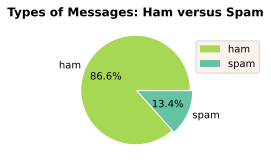

In [5]:
fig, ax = plt.subplots(figsize = (6,2.5))
lblComparison=pd.value_counts(df_original['label'], sort= True)
lblLst = lblComparison.index


# only exploding the 2nd slice 
explode = (0, 0.05)

patches, texts, auto  = ax.pie(lblComparison, labels =lblLst, explode=explode, autopct='%1.1f%%')
n = len(patches)
for i in range(n):
    x = (n-1)/n - i/n
    patches[i].set_facecolor(plt.cm.Set2(x))

#draw a circle at the center of pie to make it look like a donut
#centre_circle = plt.Circle((0,0),0.70,color='black', fc='white',linewidth=0.25)
#fig = plt.gcf()
#fig.gca().add_artist(centre_circle)
ax.set_title('Types of Messages: Ham versus Spam', fontweight="bold")
ax.legend(loc="upper right", facecolor='linen', bbox_to_anchor=(1.45, 0.9))
ax.set_ylabel('')
#plt.show()
plt.savefig(imageDirectory + '\\img_distribution_pie.png', dpi=180,  bbox_inches='tight')

In [6]:
df = df_original.copy()
df['token'] = df_original.apply(lambda row: nltk.word_tokenize(row['message']), axis=1)
df['processed_message'] = textPreprocess(df['message'])
df.head(2)

,label,message,token,processed_message
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point, ,, crazy, .., Avail...","Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, ..., Joking, wif, u, oni, ...]",Ok lar... Joking wif u oni...


### Text Comparison: Ham vs. Spam

In [7]:
# Extract text of ham and spam messages:
txtHam, txtSpam = '', ''

for text in df_original.loc[df_original['label'] == 'ham', 'message']:
    txtHam += text + ' '
for text in df_original.loc[df_original['label'] == 'spam', 'message']:
    txtSpam += text + ' '

In [8]:
hamTags = sparseTags(txtHam)
spamTags = sparseTags(txtSpam)

C:\Users\TONAS\.conda\envs\myland\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  """


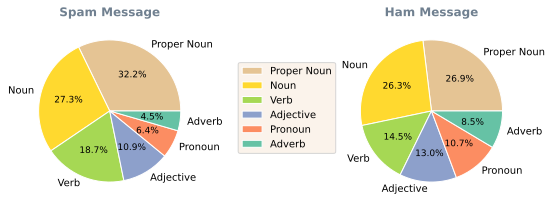

In [9]:
lblLst = ['Proper Noun', 'Noun', 'Verb', 'Adjective', 'Pronoun', 'Adverb']

#colors = cm.Set1(np.arange(6)/6.)
fig, axes = plt.subplots(1, 2, figsize = (8,3))
patches, texts, auto  = axes[0].pie(spamTags, labels = lblLst, autopct='%1.1f%%', wedgeprops={"edgecolor":'white','linewidth': 1})
plt.setp(auto, fontsize=9)
n = len(patches)
for i in range(n):
    x = (n-1)/n - i/n
    patches[i].set_facecolor(plt.cm.Set2(x))    
axes[0].set_title('Spam Message', color='slategray', fontweight="bold")
axes[0].legend(loc="upper right", facecolor='linen', bbox_to_anchor=(1.8, 0.8))
#axes[0].legend(loc="upper right", facecolor='aliceblue', bbox_to_anchor=(1.7, 0.8))
axes[0].set_ylabel('')

patches, texts, auto  = axes[1].pie(hamTags, labels = lblLst, autopct='%1.1f%%', wedgeprops={"edgecolor":'white','linewidth': 1})
plt.setp(auto, fontsize=9)
n = len(patches)
for i in range(n):
    x = (n-1)/n - i/n
    patches[i].set_facecolor(plt.cm.Set2(x))
axes[1].set_title('Ham Message', color='slategray', fontweight="bold")
axes[1].set_ylabel('')
fig.tight_layout()
#plt.show()
plt.savefig(imageDirectory + '\\img_postag_pie.png', dpi=130,  bbox_inches='tight')

In [10]:
# Direct Comparison using Bar Plot:
df_check = pd.DataFrame(spamTags, columns=['Spam'])
df_check['Ham'] = hamTags.values
df_check

,Spam,Ham
Proper Noun,0.322025,0.269245
Noun,0.272734,0.263470
Verb,0.187256,0.144756
Adjective,0.108797,0.129556
Pronoun,0.064265,0.107473
Adverb,0.044923,0.085499


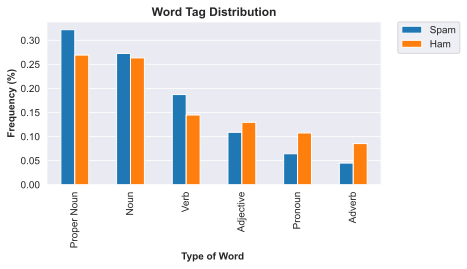

In [11]:
sns.set_style("darkgrid")
title = 'Word Tag Distribution'
ylbl = 'Frequency (%)'
xlbl = 'Type of Word '
plotComparison_df(df_check, xLabel = xlbl, yLabel = ylbl, title=title);
plt.savefig(imageDirectory + '\\img_wordtag_bar.png', dpi=120, bbox_inches='tight')

### Part of Speach Tag (pos tag) :
Word types with highligh difference:
- Features with significantly higher ratio in **SPAM**:
    - Proper Noun, Verb
- Features with significantly higher ratio in **HAM**:
    - Pronoun, Adverb, Adjective
- Features with comparible ratio:
    - Noun
    
**Point:** Since a given message may be relatively short, we can make a new Engineered Feature that joins more important charateristics of part of speach tag (pos tag):

**New Fetaure:** (Proper Noun + Verb) - (Adjective + Pronoun + Adverb)

In [12]:
df['token_processed'] = df_original['message'].apply(prepareWordCloud)

# Let's make a word cloud for frequent words
hamWordLst = []
spamWordLst = []
for tokenLst in df.loc[df['label'] == 'ham', 'token_processed'] :
    hamWordLst += tokenLst
for tokenLst in df.loc[df['label'] == 'spam', 'token_processed']:
    spamWordLst += tokenLst

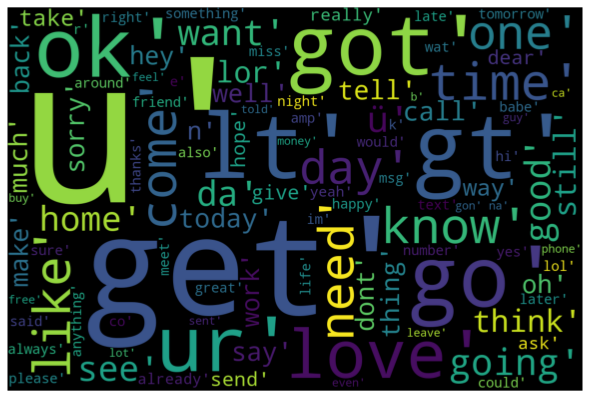

In [13]:
def wordCloudFunc(inputData, isToken = 0, max_words=100, width=1600, height=800, figsize=(15,10), bg_color='k'):
    """
    input:
    inputData: data for making word cloud
    isToken: a flag {0, 1} shows if input is in form of token or not: 0 used for text input, 1 used for token input
    export_file_name: a name used for saving file
    max_words: maximum words for word cloud, default=100,
    width= width of word cloud, default=1600, 
    height= height of word cloud, default=800, 
    figsize=size of return figure, default=(15,10), 
    facecolor=color of word cloud, default='k'
    output: 
    word cloud figure
    """
    if isToken ==1:
        inputData = str(inputData)
    #wordcloud = WordCloud(min_word_length =1,max_words=max_words, width=width, height=height, random_state=1).generate(inputData)
    wordcloud = WordCloud(max_words=max_words, width=width, height=height, background_color=bg_color).generate(inputData)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    
wordCloudFunc(hamWordLst, isToken = 1, max_words=100, width=1200, height=800, figsize=(8,6), bg_color='black')
plt.savefig(imageDirectory + '\\img_ham_wcloud.png' , dpi=300, bbox_inches='tight')

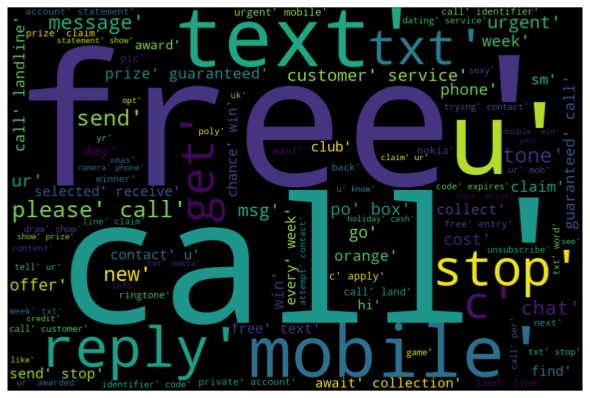

In [14]:
wordCloudFunc(spamWordLst, isToken = 1, max_words=100, width=1200, height=800, figsize=(8,6), bg_color='black')
plt.savefig(imageDirectory + '\\img_spam_wcloud.png' , dpi=300, bbox_inches='tight')

### Checking Top 20 Words

In [15]:
hamCount = Counter(hamWordLst).most_common(20)
df_hamCount = pd.DataFrame.from_dict(hamCount)
df_hamCount = df_hamCount.rename(columns={0: "word", 1 : "count"})

spamCount = Counter(spamWordLst).most_common(20)
df_spamCount = pd.DataFrame.from_dict(spamCount)
df_spamCount = df_spamCount.rename(columns={0: "word", 1 : "count"})

C:\Users\TONAS\.conda\envs\myland\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


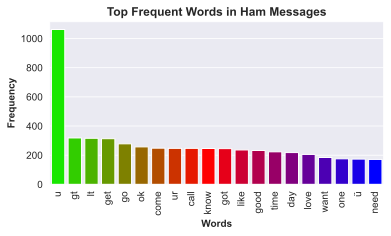

In [16]:
titleTxt = 'Top Frequent Words in Ham Messages'
make_bar_plot(X=df_hamCount['word'], y=df_hamCount['count'], title=titleTxt, xlbl='Words', ylbl='Frequency', xRotation=90);
plt.savefig(imageDirectory + '\\img_top20_ham.png', dpi=150, bbox_inches='tight')

C:\Users\TONAS\.conda\envs\myland\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


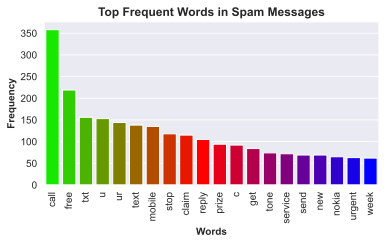

In [17]:
titleTxt = 'Top Frequent Words in Spam Messages'
make_bar_plot(X=df_spamCount['word'], y=df_spamCount['count'], title=titleTxt, xlbl='Words', ylbl='Frequency', xRotation=90);
plt.savefig(imageDirectory + '\\img_top20_spam.png', dpi=140, bbox_inches='tight')

### Feature Engineering:

In [18]:
##########################################################################################
#                   Group1- Features using the tokenized version of text
##########################################################################################
# 1- Finding count of tokens in each messgae
df['token_count'] = df['token'].apply(findTokenCount)

# 2- Finding average length of words in each messgae
df['avg_word_length'] = df['token'].apply(findAVGWordLen)

# 3- Finding count of uppercase words in each messgae
df['upper_count'] = df['token'].apply(findUpperWord)

# 4- Finding count of stopwords in each messgae
df['stop_count'] = df['token'].apply(findStopWord)

# 5- Finding count of numerical words in in each messgae
df['num_count'] = df['token'].apply(findNumericWord)

# 6- Check if message has numerical word or not
df['hasNumber'] = np.where(df['num_count'] == 0, 0, 1)


##########################################################################################
#                          Group2- Features using the original text
##########################################################################################
# 7- Finding count of punctuations in each messgae
df['punc_count'] = df['message'].apply(findPunctuationCount)

# 8- Finding a feature based on pos tag analysis already done
df['pos_tag'] = df['message'].apply(findPosTagFeature)


##########################################################################################
#                    Group3- Features using the processed version of text
##########################################################################################
# 9- Check if message has phone number or not
df['hasPhone'] = [1 if '(Pho_plh)' in line else 0 for line in df['processed_message']]

# 10- Check if message has currency symbol or not
df['hasCurrency'] = [1 if '(Cur_plh)' in line else 0 for line in df['processed_message']]

# 11- Check if message has URL or not
df['hasURL'] = [1 if '(Url_plh)' in line else 0 for line in df['processed_message']]

# 12- Check if message has email address or not
df['hasEmail'] = [1 if '(Eml_plh)' in line else 0 for line in df['processed_message']]

##########################################################################################
#                          Group4- Features made over other features
##########################################################################################
df['sum_has_features'] = df['hasNumber'] + df['hasCurrency'] + df['hasPhone'] + df['hasURL']
df['sum_count_features'] = df['num_count'] + df['upper_count'] + df['punc_count']

C:\Users\TONAS\.conda\envs\myland\lib\site-packages\ipykernel_launcher.py:157: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


### Explanatory Data Analysis of Engineered Features:

### 1- Visualizing Count of Token in Messages

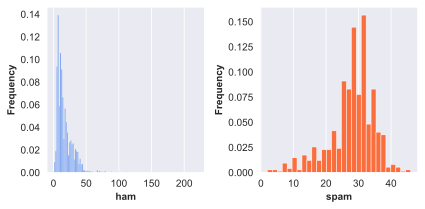

In [19]:
makeHist(df, 'token_count');

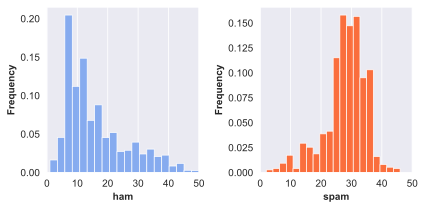

In [20]:
makeHist(df, 'token_count', x_range= (0, 50), bins = 20);

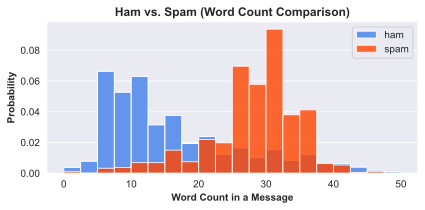

In [21]:
#sns.set_style("whitegrid", {'axes.grid' : False})
xlbl = 'Word Count in a Message'
title = 'Ham vs. Spam (Word Count Comparison)'
makeHistOneFigure(df, col='token_count', x_label=xlbl, title=title, x_range= (0, 50), bins = 20);
plt.savefig(imageDirectory + '\\img_word_count_hist.png', dpi=140,  bbox_inches='tight')

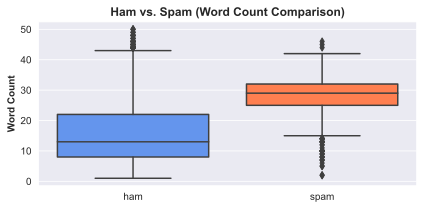

In [22]:
ylbl = 'Word Count'
title = 'Ham vs. Spam (Word Count Comparison)'
make_box_plot(df, col='label', refCol='token_count', x_range=(0, 50), y_label=ylbl, title=title, xRotation=0)
plt.savefig(imageDirectory + '\\img_word_count_box.png', dpi=140,  bbox_inches='tight')

### 2- Visualizing Average Word Length in Messages

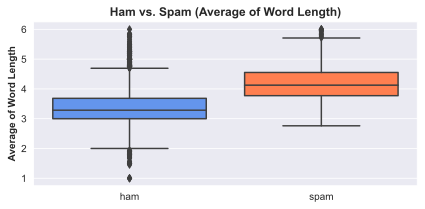

In [23]:
ylbl = 'Average of Word Length'
title = 'Ham vs. Spam (Average of Word Length)'
make_box_plot(df, col='label', refCol='avg_word_length', x_range=(0, 6), y_label=ylbl, title=title, xRotation=0)
plt.savefig(imageDirectory + '\\img_word_length_box.png', dpi=140,  bbox_inches='tight')

### 3- Visualizing of Count of Uppercase Word  in Messages

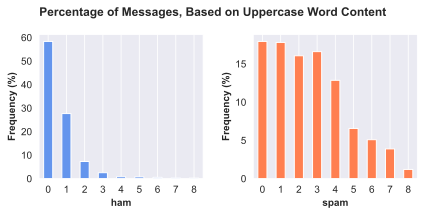

In [24]:
spamUpperCase = df.loc[df['label']=='spam', 'upper_count'].value_counts(normalize=True)
hamUpperCase = df.loc[df['label']=='ham', 'upper_count'].value_counts(normalize=True)
title = 'Percentage of Messages, Based on Uppercase Word Content'
make_multiple_bar_plot(hamUpperCase, spamUpperCase, max_index=8, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=False)
plt.savefig(imageDirectory + '\\img_uppercase_bar.png', dpi=140,  bbox_inches='tight')

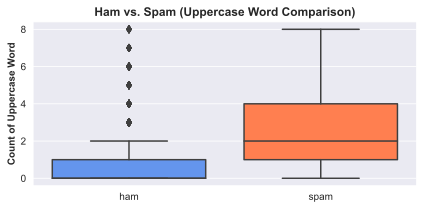

In [25]:
ylbl = 'Count of Uppercase Word'
title = 'Ham vs. Spam (Uppercase Word Comparison)'
make_box_plot(df, col='label', refCol='upper_count', x_range=(0, 8), y_label=ylbl, title=title, xRotation=0)
plt.savefig(imageDirectory + '\\img_uppercase_box.png', dpi=140,  bbox_inches='tight')

### 4- Visualizing of Count of Stopwords  in Messages

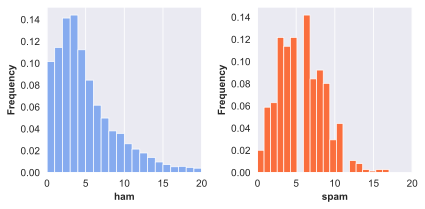

In [26]:
makeHist(df, 'stop_count', x_range= (0, 20), bins = 20);

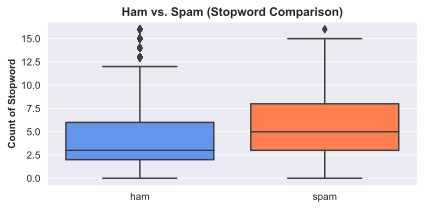

In [27]:
ylbl = 'Count of Stopword'
title = 'Ham vs. Spam (Stopword Comparison)'
make_box_plot(df, col='label', refCol='stop_count', x_range= (0, 16), y_label=ylbl, title=title, xRotation=0)
plt.savefig(imageDirectory + '\\img_stopword_box.png', dpi=140,  bbox_inches='tight')

### 5- Visualizing of Numerical Content  in Messages

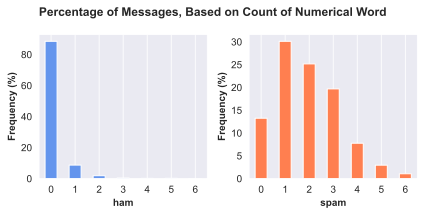

In [28]:
hamNumerical = df.loc[df['label']=='ham', 'num_count'].value_counts(normalize=True)
spamNumerical = df.loc[df['label']=='spam', 'num_count'].value_counts(normalize=True)
title = 'Percentage of Messages, Based on Count of Numerical Word'
make_multiple_bar_plot(hamNumerical, spamNumerical, max_index=6, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=False)
plt.savefig(imageDirectory + '\\img_numword_count_bar.png', dpi=140,  bbox_inches='tight')

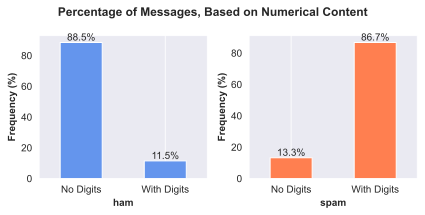

In [29]:
hamNumerical = df.loc[df['label']=='ham', 'hasNumber'].value_counts(normalize=True)
spamNumerical = df.loc[df['label']=='spam', 'hasNumber'].value_counts(normalize=True)
title = 'Percentage of Messages, Based on Numerical Content'
xtick_lbl = ['No Digits', 'With Digits']
make_multiple_bar_plot(hamNumerical, spamNumerical, max_index=6, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=True, xtick_label = xtick_lbl)
plt.savefig(imageDirectory + '\\img_has_numerical_bar.png', dpi=140,  bbox_inches='tight')

### 6- Visualizing of Count of Punctuation in Messages

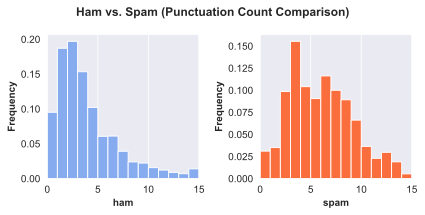

In [30]:
title = 'Ham vs. Spam (Punctuation Count Comparison)'
makeHist(df, 'punc_count', title = title, x_range= (0, 15), bins = 15);
plt.savefig(imageDirectory + '\\img_punc_bar.png', dpi=140,  bbox_inches='tight')

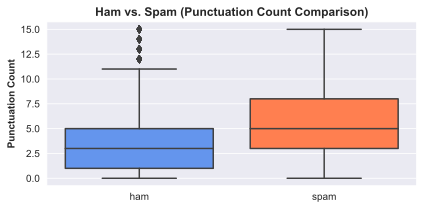

In [31]:
ylbl = 'Punctuation Count'
title = 'Ham vs. Spam (Punctuation Count Comparison)'
make_box_plot(df, col='label', refCol='punc_count', x_range=(0, 15), y_label=ylbl, title=title, xRotation=0)
plt.savefig(imageDirectory + '\\img_punc_box.png', dpi=140,  bbox_inches='tight')

### 7- Visualizing of Phone Number Presence in Messages

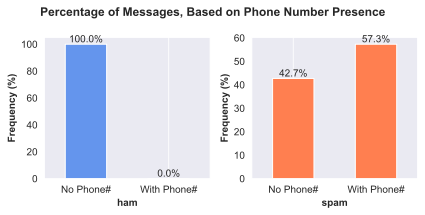

In [32]:
hamPhoneNum = df.loc[df['label']=='ham', 'hasPhone'].value_counts(normalize=True)
spamPhoneNum = df.loc[df['label']=='spam', 'hasPhone'].value_counts(normalize=True)
title = 'Percentage of Messages, Based on Phone Number Presence'
xtick_lbl = ['No Phone#', 'With Phone#']
make_multiple_bar_plot(hamPhoneNum, spamPhoneNum, max_index=6, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=True, xtick_label = xtick_lbl)
plt.savefig(imageDirectory + '\\img_has_phone_bar.png', dpi=140,  bbox_inches='tight')

### 8- Visualizing of Currency Presence in Messages

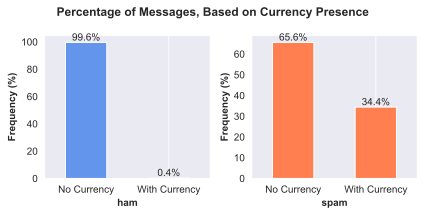

In [33]:
hamCurrency = df.loc[df['label']=='ham', 'hasCurrency'].value_counts(normalize=True)
spamCurrency = df.loc[df['label']=='spam', 'hasCurrency'].value_counts(normalize=True)
title = 'Percentage of Messages, Based on Currency Presence'
xtick_lbl = ['No Currency', 'With Currency']
make_multiple_bar_plot(hamCurrency, spamCurrency, max_index=6, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=True, xtick_label = xtick_lbl)
plt.savefig(imageDirectory + '\\img_has_currency_bar.png', dpi=140,  bbox_inches='tight')

### 9- Visualizing of URL Presence in Messages

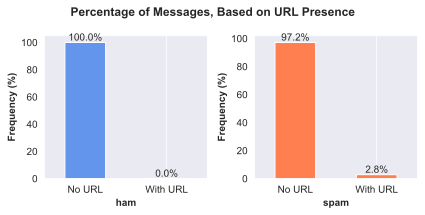

In [34]:
hamURL = df.loc[df['label']=='ham', 'hasURL'].value_counts(normalize=True)
if(1 not in hamURL):
    hamURL.loc[1] = 0
spamURL = df.loc[df['label']=='spam', 'hasURL'].value_counts(normalize=True)
title = 'Percentage of Messages, Based on URL Presence'
xtick_lbl = ['No URL', 'With URL']
make_multiple_bar_plot(hamURL, spamURL, max_index=6, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=True, xtick_label = xtick_lbl)
plt.savefig(imageDirectory + '\\img_has_url_bar.png', dpi=140,  bbox_inches='tight')

### 10- Visualizing of Email Address Presence in Messages

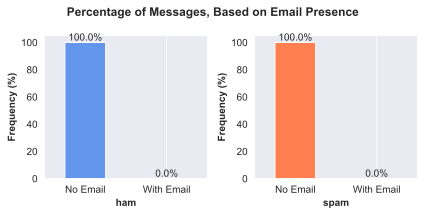

In [35]:
hamEmail = df.loc[df['label']=='ham', 'hasEmail'].value_counts(normalize=True)
spamEmail = df.loc[df['label']=='spam', 'hasEmail'].value_counts(normalize=True)
if(1 not in hamEmail):
    hamEmail.loc[1] = 0
if(1 not in spamEmail):
    spamEmail.loc[1] = 0    
title = 'Percentage of Messages, Based on Email Presence'
xtick_lbl = ['No Email', 'With Email']
make_multiple_bar_plot(hamEmail, spamEmail, max_index=6, sort_index = True, y_label=None, figTitle=title,xRotation=0, annotation=True, xtick_label = xtick_lbl)
plt.savefig(imageDirectory + '\\img_has_email_bar.png', dpi=140,  bbox_inches='tight')

### Droping non effective features

In [36]:
df.drop(['hasEmail', 'hasURL'], axis=1, inplace=True)

### Saving datasets

In [37]:
cols = [x for x in df.columns if x not in ('message', 'token', 'processed_message', 'token_processed')]
df_new = df[cols]
df_source = df[['label', 'message', 'token']]
df_new.to_csv((os.path.join(dataDirectory,'df_new2.csv')), index=False)
df_source.to_csv((os.path.join(dataDirectory,'df_source2.csv')), index=False)